# Inspect Trained Models

In [1]:
%load_ext autoreload
%autoreload 2

In [79]:
import os
from pathlib import Path

import numpy as np
from PIL import Image
import numpy as np
import os
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.datasets.utils as dataset_utils
import normflows as nf

from gendis.datasets import CausalMNIST, ClusteredMultiDistrDataModule
from gendis.model import NeuralClusteredASCMFlow
from gendis.variational.vae import VAE

import matplotlib.pyplot as plt
import seaborn as sns

from torchvision.datasets import MNIST
from torchvision import transforms
import pytorch_lightning as pl


In [3]:
import math
import torchvision

def show_imgs(imgs, title=None, row_size=4):
    # Form a grid of pictures (we use max. 8 columns)
    num_imgs = imgs.shape[0] if isinstance(imgs, torch.Tensor) else len(imgs)
    is_int = imgs.dtype==torch.int32 if isinstance(imgs, torch.Tensor) else imgs[0].dtype==torch.int32
    nrow = min(num_imgs, row_size)
    ncol = int(math.ceil(num_imgs/nrow))
    imgs = torchvision.utils.make_grid(imgs, nrow=nrow, pad_value=128 if is_int else 0.5)
    np_imgs = imgs.cpu().numpy()
    # Plot the grid
    plt.figure(figsize=(1.5*nrow, 1.5*ncol))
    plt.imshow(np.transpose(np_imgs, (1,2,0)), interpolation='nearest')
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.show()
    plt.close()

In [94]:
# get the images
graph_type = 'chain'
root = '/Users/adam2392/pytorch_data/'
# Convert images from 0-1 to 0-255 (integers)
def discretize(sample):
    return (sample * 255).to(torch.int32)

# Transformations applied on each image => make them a tensor and discretize
transform = transforms.Compose([transforms.ToTensor(),
                                # nf.utils.Scale(255.0 / 256.0),  # normalize the pixel values
                                nf.utils.Jitter(1 / 256.0),  # apply random generation
                                discretize,
                               ])

dataset = CausalMNIST(root=root, graph_type=graph_type, label=0, download=True, train=True, n_jobs=None, intervention_idx=None,
                     transform=transform)
dataset.prepare_dataset(overwrite=False)

img, metadata = dataset[0]
print(img.shape)



Loading dataset from "/Users/adam2392/pytorch_data/CausalMNIST/chain/chain-0-train.pt"
torch.Size([3, 28, 28])


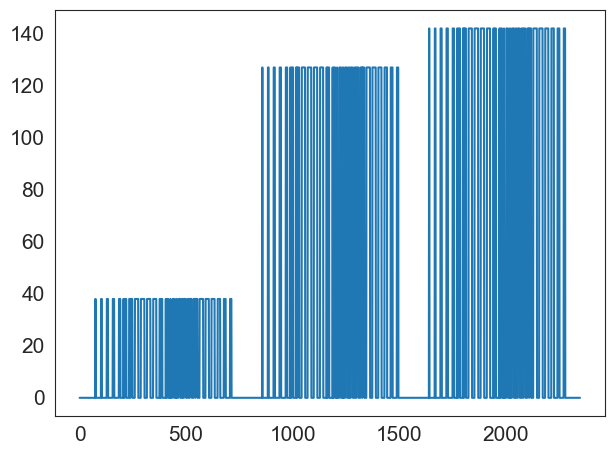

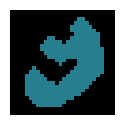

In [95]:
# img = img / img.max()
plt.plot(img.flatten())
# sns.histplot(img.flatten())
show_imgs(img)

In [71]:
import normflows as nf

# set up transforms for each image to augment the dataset
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        nf.utils.Jitter(1 / 256.0),  # apply random generation
        nf.utils.Scale(255.0 / 256.0),  # normalize the pixel values
        nf.utils.Scale(1. / 256.0),  # normalize the pixel values
        torchvision.transforms.RandomRotation(350),  # get random rotations
    ]
)

# load dataset
datasets = []
intervention_targets_per_distr = []
hard_interventions_per_distr = None
num_distrs = 0
for intervention_idx in [None]:
    dataset = CausalMNIST(
        root=root,
        graph_type=graph_type,
        label=0,
        download=True,
        train=True,
        n_jobs=None,
        intervention_idx=intervention_idx,
        transform=transform,
    )
    dataset.prepare_dataset(overwrite=False)
    datasets.append(dataset)
    num_distrs += 1
    intervention_targets_per_distr.append(dataset.intervention_targets)


NameError: name 'root' is not defined

In [146]:
# now we can wrap this in a pytorch lightning datamodule
data_module = ClusteredMultiDistrDataModule(
    datasets=datasets,
    num_workers=2,
    batch_size=16,
    intervention_targets_per_distr=intervention_targets_per_distr,
    log_dir='./',
    flatten=False,
)
data_module.setup()

torch.Size([23692, 3, 28, 28]) 6 torch.Size([23692]) torch.Size([23692]) torch.Size([23692])


tensor(42.) tensor(142.)
tensor(0.) tensor(142.)
tensor(0.) tensor(136.)
tensor(0.) tensor(143.)
tensor(0.) tensor(142.)
tensor(0.) tensor(148.)
tensor(0.) tensor(141.)
tensor(0.) tensor(185.)
tensor(0.) tensor(142.)
tensor(0.) tensor(141.)
tensor(0.) tensor(141.)
tensor(0.) tensor(142.)
tensor(0.) tensor(142.)
tensor(0.) tensor(186.)
tensor(0.) tensor(141.)
tensor(0.) tensor(142.)


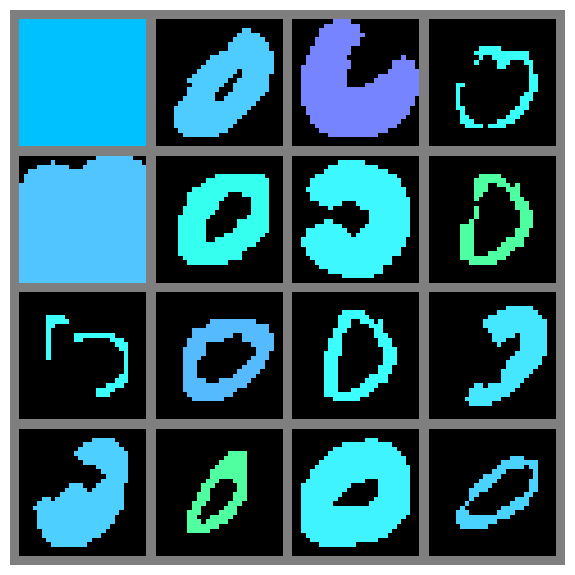

In [149]:

(imgs, width,
        color,
        fracture_thickness,
        fracture_num_fractures,
        label,
        distr_indicators,
        intervention_targets,
    ) = next(iter(data_module.train_dataloader()))

# new_obs_imgs = imgs
new_obs_imgs = torch.zeros_like(imgs)
for idx, image in enumerate(imgs):
    print(image.min(), image.max())
    image = (image - image.min()) / (image.max() - image.min())
    new_obs_imgs[idx, ...] = image

show_imgs(new_obs_imgs)

In [144]:
print(imgs[0].flatten().max(), imgs[0].flatten().min())

tensor(143.) tensor(0.)


# Demo Trained Model Reproducing Images

Here, we are interested in qualitatively analyzing the trained model. This will entail

In [ ]:
seed = 2
graph_type = 'chain'
# Sub this model filename in when we support it and run new models
model_fname = f"{graph_type}-seed={seed}-model.pt"

results_dir = Path(f'/Users/adam2392/pytorch_data/data/chain-seed={seed}/')
model = torch.load(results_dir / model_fname, map_location=torch.device('cpu'))

In [130]:
print([img.shape for img in imgs])

[torch.Size([5, 3, 28, 28]), torch.Size([5, 3, 28, 28]), torch.Size([5, 3, 28, 28]), torch.Size([5, 3, 28, 28]), torch.Size([5, 3, 28, 28])]


In [95]:
# sample from the trained encoder
encoder = model.encoder
print(encoder.causalq0)

NonparametricClusteredCausalDistribution(
  (q0): MultiEnvBaseDistribution()
  (flows): ModuleList(
    (0-2): 3 x AutoregressiveRationalQuadraticSpline(
      (mprqat): MaskedPiecewiseRationalQuadraticAutoregressive(
        (autoregressive_net): MADE(
          (preprocessing): Identity()
          (initial_layer): MaskedLinear(in_features=2352, out_features=128, bias=True)
          (blocks): ModuleList(
            (0-2): 3 x MaskedResidualBlock(
              (linear_layers): ModuleList(
                (0-1): 2 x MaskedLinear(in_features=128, out_features=128, bias=True)
              )
              (activation): ReLU()
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): MaskedLinear(in_features=128, out_features=54096, bias=True)
        )
      )
    )
  )
)


In [94]:
print(encoder.sample()[0].shape)

TypeError: BaseDistribution.sample() takes from 1 to 2 positional arguments but 3 were given

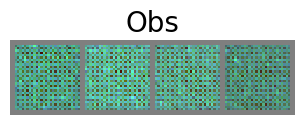

In [69]:
obs_imgs = encoder.sample(num_samples=4)[0]

new_obs_imgs = torch.zeros_like(obs_imgs)
for idx, image in enumerate(obs_imgs):
    image = (image - image.min()) / (image.max() - image.min())
    new_obs_imgs[idx, ...] = image
    
show_imgs(new_obs_imgs, title='Obs')

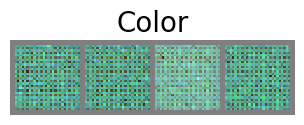

In [70]:
obs_imgs = encoder.sample(num_samples=4, intervention_targets=torch.Tensor([0, 0, 1]))[0]

new_obs_imgs = torch.zeros_like(obs_imgs)
for idx, image in enumerate(obs_imgs):
    image = (image - image.min()) / (image.max() - image.min())
    new_obs_imgs[idx, ...] = image
    
show_imgs(new_obs_imgs, title='Color')

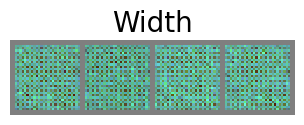

In [72]:
obs_imgs = encoder.sample(num_samples=4, intervention_targets=torch.Tensor([1, 0, 0]))[0]

new_obs_imgs = torch.zeros_like(obs_imgs)
for idx, image in enumerate(obs_imgs):
    image = (image - image.min()) / (image.max() - image.min())
    new_obs_imgs[idx, ...] = image
    
show_imgs(new_obs_imgs, title='Width')

# Load a Checkpoint and see

In [98]:
seed=2
graph_type='chain'
epoch=408
step=8589
results_dir = Path(f'/Users/adam2392/pytorch_data/data/{graph_type}-seed={seed}/')
checkpoint_fname = results_dir / f'epoch={epoch}-step={step}.ckpt'
model = NeuralClusteredASCMFlow.load_from_checkpoint(checkpoint_fname)

/Users/adam2392/miniforge3/envs/cdrl/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
  rank_zero_warn(


In [101]:
encoder= model.encoder

print(encoder.causalq0)

ClusteredCausalDistribution(
  (coeff_values): ParameterList(
      (0): Object of type: ParameterList
      (1): Object of type: ParameterList
      (2): Object of type: ParameterList
    (0): ParameterList(  (0): Parameter containing: [torch.float32 of size 784])
    (1): ParameterList(
        (0): Parameter containing: [torch.float32 of size 784]
        (1): Parameter containing: [torch.float32 of size 784]
    )
    (2): ParameterList(
        (0): Parameter containing: [torch.float32 of size 784]
        (1): Parameter containing: [torch.float32 of size 784]
    )
  )
  (noise_means): ParameterList(
      (0): Object of type: ParameterList
      (1): Object of type: ParameterList
      (2): Object of type: ParameterList
      (3): Object of type: ParameterList
    (0): ParameterList(
        (0): Parameter containing: [torch.float32 of size 784]
        (1): Parameter containing: [torch.float32 of size 784]
        (2): Parameter containing: [torch.float32 of size 784]
    )
   

In [103]:
# run a test to make sure this actually works
rand_img = torch.arange(28*28*3, dtype=torch.float32).view(1, 3, 28, 28)
out = encoder.forward(rand_img)
print(encoder.inverse_and_log_det(rand_img)[0].shape)

torch.Size([1, 2352])


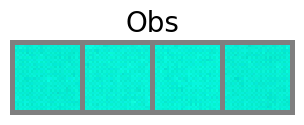

In [104]:
obs_imgs = encoder.sample(num_samples=4)[0]

new_obs_imgs = torch.zeros_like(obs_imgs)
for idx, image in enumerate(obs_imgs):
    image = (image - image.min()) / (image.max() - image.min())
    new_obs_imgs[idx, ...] = image
    
show_imgs(new_obs_imgs, title='Obs')

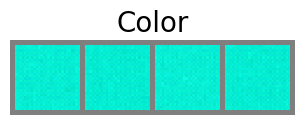

In [105]:
obs_imgs = encoder.sample(num_samples=4, intervention_targets=torch.Tensor([0, 0, 1]))[0]

new_obs_imgs = torch.zeros_like(obs_imgs)
for idx, image in enumerate(obs_imgs):
    image = (image - image.min()) / (image.max() - image.min())
    new_obs_imgs[idx, ...] = image
    
show_imgs(new_obs_imgs, title='Color')

# VAE Inspection

In [49]:
import torch.nn as nn
import torchvision
from pl_bolts.models.autoencoders.components import resnet18_decoder, resnet18_encoder

/Users/adam2392/miniforge3/envs/cdrl/lib/python3.10/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/Users/adam2392/miniforge3/envs/cdrl/lib/python3.10/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/Users/adam2392/miniforge3/envs/cdrl/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/Users/adam2392/miniforge3/envs/cdrl/lib/python3.

In [50]:

class Stack(nn.Module):
    def __init__(self, channels, height, width):
        super(Stack, self).__init__()
        self.channels = channels
        self.height = height
        self.width = width

    def forward(self, x):
        print(x.shape)
        return x.view(x.size(0), self.channels, self.height, self.width)


# Stride 2 by default
def ConvBlock(in_channels, out_channels, kernel_size):
    return nn.Sequential(
        nn.Conv2d(
            in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=2
        ),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )


# Stride 2 by default
def DeconvBlock(
    in_channels, out_channels, kernel_size, stride=2, padding=1, output_padding=1, last=False
):
    if not last:
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                output_padding=output_padding,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    return nn.Sequential(
        nn.ConvTranspose2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            output_padding=output_padding,
        ),
        nn.Tanh(),
    )

In [6]:
seed=1
graph_type='chain'

results_dir = Path(f'/Users/adam2392/pytorch_data/data/variational/vae-withonlysigmoid-{graph_type}-seed={seed}/')
model_fname = f'vae-{graph_type}-seed={seed}-model.pt'
model = torch.load(results_dir / model_fname, map_location=torch.device('cpu'))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/adam2392/pytorch_data/data/variational/vae-chain-seed=1/vae-chain-seed=1-model.pt'

In [21]:
seed=2
graph_type='chain'
epoch=3129
step=131460
epoch=423
step=17808
results_dir = Path(f'/Users/adam2392/pytorch_data/data/variational/vae-withonlysigmoid-{graph_type}-seed={seed}/')
checkpoint_fname = results_dir / f'epoch={epoch}-step={step}.ckpt'
model = VAE.load_from_checkpoint(checkpoint_fname)

In [31]:
# sample from normal distribution
noise = torch.randn(4, 3)
obs_imgs = model.decoder(noise)#.reshape(4, 3, 28, 28)
print(obs_imgs.shape)

torch.Size([4, 1024])
torch.Size([4, 3, 28, 28])


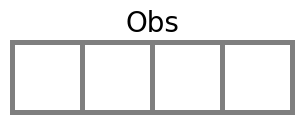

In [32]:
# new_obs_imgs = torch.zeros_like(obs_imgs)
# for idx, image in enumerate(obs_imgs):
#     image = (image - image.min()) / (image.max() - image.min())
#     new_obs_imgs[idx, ...] = image
    
show_imgs(obs_imgs, title='Obs')

In [33]:
print(obs_imgs.max(), obs_imgs.min())

tensor(1., grad_fn=<MaxBackward1>) tensor(1., grad_fn=<MinBackward1>)


torch.Size([4, 1024])


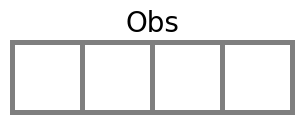

In [48]:
n = 3
z1 = torch.linspace(-0, 1, n)
z2 = torch.zeros_like(z1) + 2
z = torch.stack([z1, z2], dim=-1).to('cpu')
z = torch.randn(4, 3)
samples = model.decode(z)
# samples = torch.sigmoid(samples)

show_imgs(samples, title='Obs')

## VAE with ResNet

In [154]:
seed=1
graph_type='chain'
epoch=3129
step=131460
epoch=6207
step=260736
results_dir = Path(f'/Users/adam2392/pytorch_data/data/variational/vae-resnet-{graph_type}-seed={seed}/')
checkpoint_fname = results_dir / f'epoch={epoch}-step={step}.ckpt'
model = VAE.load_from_checkpoint(checkpoint_fname)

In [155]:
# sample from normal distribution
noise = torch.randn(4, 3)
obs_imgs = model.decoder(noise)#.reshape(4, 3, 28, 28)
print(obs_imgs.shape)

torch.Size([4, 3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0618, grad_fn=<MinBackward1>) tensor(0.7368, grad_fn=<MaxBackward1>)


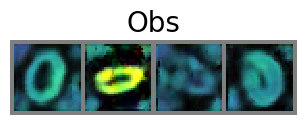

In [156]:
new_obs_imgs = torch.zeros_like(obs_imgs)
for idx, image in enumerate(obs_imgs):
    new_image = (image - image.min()) / (image.max() - image.min())
    new_obs_imgs[idx, ...] = new_image

print(image.min(), image.max())
    
show_imgs(obs_imgs, title='Obs')

In [72]:
checkpoint = torch.load(checkpoint_fname, map_location=lambda storage, loc: storage)
print(checkpoint['epoch'])

9988


# Noncausal Normalizing Flow

In [4]:
from gendis.noncausal.flows import (
    CouplingLayer,
    Dequantization,
    GatedConvNet,
    Reshape,
    VariationalDequantization,
    create_channel_mask,
    create_checkerboard_mask,
)
from gendis.noncausal.model import ImageFlow

In [27]:
seed=6
graph_type='chain'
epoch=2002
step=42063
results_dir = Path(f'/Users/adam2392/pytorch_data/data/noncausalflow/nf-nochannelmask-clipgrad-batch1024-{graph_type}-seed={seed}/')
checkpoint_fname = results_dir / f'epoch={epoch}-step={step}.ckpt'
model = ImageFlow.load_from_checkpoint(checkpoint_fname)

/Users/adam2392/miniforge3/envs/cdrl/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'prior' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['prior'])`.
  rank_zero_warn(


In [47]:
# sample from normal distribution
num_samples = 4
img_shape = (num_samples, 3, 28, 28)
noise = torch.randn(num_samples, 28*28*3)# * 256
z = model.prior.log_prob(noise)
# Transform z to x by inverting the flows
ldj = torch.zeros(img_shape[0])
for idx, flow in enumerate(reversed(model.flows)):
    # print(idx, flow)
    
    z, ldj = flow(z, ldj, reverse=True)
    if idx == len(model.flows) - 2:
        break

print(z.min(), z.max())
obs_imgs = z.type(torch.uint16)

tensor(-19.0522, grad_fn=<MinBackward1>) tensor(-5.0460, grad_fn=<MaxBackward1>)


In [49]:
new_obs_imgs = torch.zeros_like(obs_imgs)
for idx, image in enumerate(obs_imgs):
    new_image = (image - image.min()) / (image.max() - image.min())
    new_obs_imgs[idx, ...] = new_image

print(image.min(), image.max())
    
show_imgs(new_obs_imgs, title='Obs')

RuntimeError: "min_all" not implemented for 'UInt16'

In [148]:
# sample from normal distribution
num_samples = 4
img_shape = (num_samples, 3, 28, 28)
noise = torch.randn(img_shape)
noise = noise / noise.max() #* 255.
noise.type(torch.int)

# Transform z to x by inverting the flows
ldj = torch.zeros(img_shape[0])
for idx, flow in enumerate((model.flows)):
    z, ldj = flow(noise, ldj, reverse=True)
    # if idx == len(model.flows) - 2:
    #     break

print(z.min(), z.max())
obs_imgs = z

tensor(-1.0446) tensor(1.)


tensor(0, dtype=torch.int32) tensor(1, dtype=torch.int32)
tensor(0, dtype=torch.int32) tensor(2, dtype=torch.int32)
tensor(0, dtype=torch.int32) tensor(3, dtype=torch.int32)


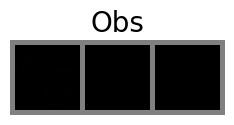

In [24]:
obs_imgs = model.sample(img_shape=[3,3,28,28])
new_obs_imgs = torch.zeros_like(obs_imgs)
for idx, image in enumerate(obs_imgs):
    print(image.min(), image.max())
    new_image = (image - image.min()) / (image.max() - image.min())
    new_obs_imgs[idx, ...] = new_image
show_imgs(new_obs_imgs, title='Obs')

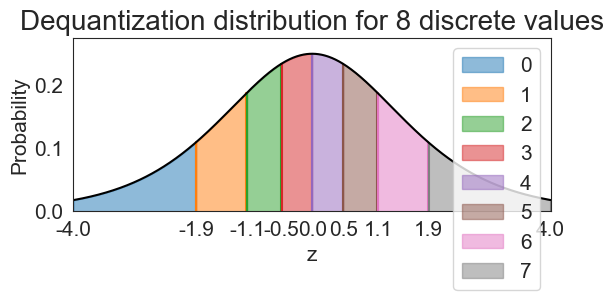

In [26]:
from matplotlib.colors import to_rgb
def visualize_dequantization(quants, prior=None):
    """
    Function for visualizing the dequantization values of discrete values in continuous space
    """
    # Prior over discrete values. If not given, a uniform is assumed
    if prior is None:
        prior = np.ones(quants, dtype=np.float32) / quants
    prior = prior / prior.sum()  # Ensure proper categorical distribution

    inp = torch.arange(-4, 4, 0.01).view(-1, 1, 1, 1) # Possible continuous values we want to consider
    ldj = torch.zeros(inp.shape[0])
    dequant_module = Dequantization(quants=quants)
    # Invert dequantization on continuous values to find corresponding discrete value
    out, ldj = dequant_module.forward(inp, ldj, reverse=True)
    inp, out, prob = inp.squeeze().numpy(), out.squeeze().numpy(), ldj.exp().numpy()
    prob = prob * prior[out] # Probability scaled by categorical prior
    
    # Plot volumes and continuous distribution
    sns.set_style("white")
    fig = plt.figure(figsize=(6,3))
    x_ticks = []
    for v in np.unique(out):
        indices = np.where(out==v)
        color = to_rgb(f"C{v}")
        plt.fill_between(inp[indices], prob[indices], np.zeros(indices[0].shape[0]), color=color+(0.5,), label=str(v))
        plt.plot([inp[indices[0][0]]]*2,  [0, prob[indices[0][0]]],  color=color)
        plt.plot([inp[indices[0][-1]]]*2, [0, prob[indices[0][-1]]], color=color)
        x_ticks.append(inp[indices[0][0]])
    x_ticks.append(inp.max())
    plt.xticks(x_ticks, [f"{x:.1f}" for x in x_ticks])
    plt.plot(inp,prob, color=(0.0,0.0,0.0))
    # Set final plot properties
    plt.ylim(0, prob.max()*1.1)
    plt.xlim(inp.min(), inp.max())
    plt.xlabel("z")
    plt.ylabel("Probability")
    plt.title(f"Dequantization distribution for {quants} discrete values")
    plt.legend()
    plt.show()
    plt.close()
    
visualize_dequantization(quants=8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.) tensor(256.)


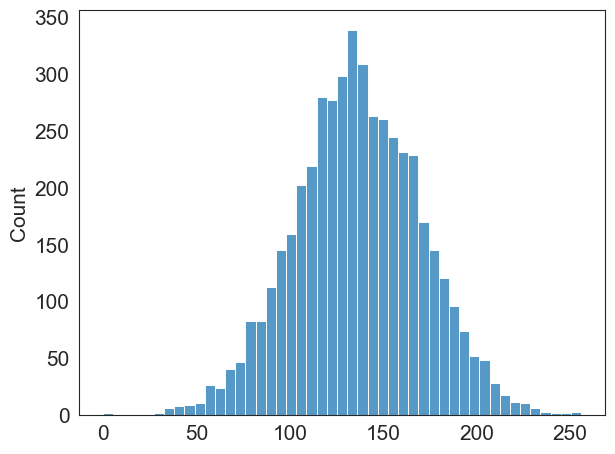

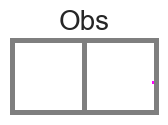

In [50]:
use_vardeq = True

flow_layers = []
n_flows = 8
if use_vardeq:
    vardeq_layers = [
        CouplingLayer(
            network=GatedConvNet(c_in=6, c_out=6, c_hidden=16),
            mask=create_checkerboard_mask(h=28, w=28, invert=(i % 2 == 1)),
            c_in=3,
        )
        for i in range(1)
    ]
    # flow_layers += vardeq_layers
    flow_layers += [VariationalDequantization(var_flows=vardeq_layers)]
else:
    flow_layers += [Dequantization()]
output, ldj = torch.randn(2, 3, 28, 28), 0
output = (output - output.min())
output = output / output.max() * 256
print(output.min(), output.max())
# output = output.type(torch.uint16)
sns.histplot(output.flatten())
show_imgs(output, title='Obs')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Running:  <class 'gendis.noncausal.flows.VariationalDequantization'> [torch.Size([3, 28, 28]), torch.Size([3, 28, 28])]
tensor(nan, grad_fn=<MaxBackward1>) tensor(nan, grad_fn=<MinBackward1>)


/Users/adam2392/miniforge3/envs/cdrl/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


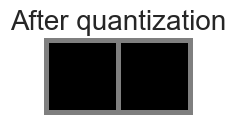

<Axes: ylabel='Count'>

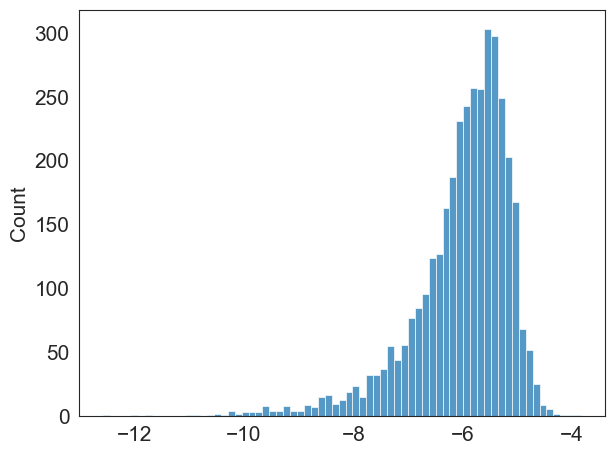

In [52]:
for flow in flow_layers:
    output, ldj = flow(output, ldj)
    print("Running: ", type(flow), [x.shape for x in output])

print(output.max(), output.min())
show_imgs(output, title='After quantization')

sns.histplot(output.flatten().detach().numpy())

In [69]:
from torchvision.datasets import MNIST
from torchvision import transforms
import pytorch_lightning as pl
# Convert images from 0-1 to 0-255 (integers)
def discretize(sample):
    return (sample * 255).to(torch.int32)

# Transformations applied on each image => make them a tensor and discretize
transform = transforms.Compose([transforms.ToTensor(),
                                # discretize
                               ])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = MNIST(root='/Users/adam2392/pytorch_data/', train=True, 
                      transform=transform, 
                      download=True)
pl.seed_everything(42)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])


Global seed set to 42


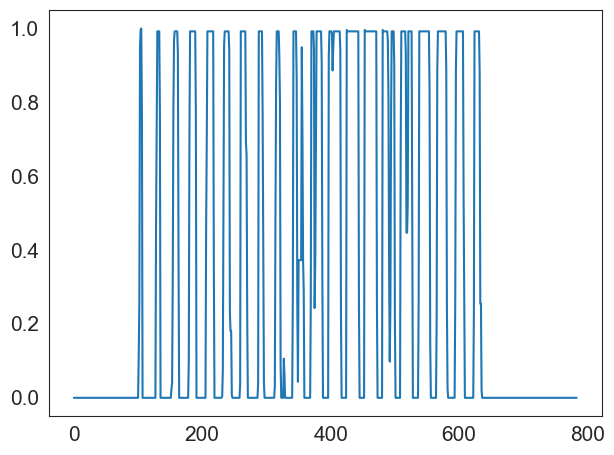

In [70]:
plt.plot(train_set[0][0].flatten())